### References

[1] J.B. Allen and D.A. Berkley, "Image method for efficiently simulating small-room acoustics," Journal Acoustic Society of America, 65(4), April 1979, p 943.

[2]  P. Peterson, "Simulating the response of multiple microphones to a single acoustic source in a reverberant room", Journal of the Acoustical Society of America, vol. 80, no. 5, pp. 1527{1529, Nov. 1986.

In [1]:
import rir_generator as RG
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython 
from scipy.io.wavfile import write, read

### Define Real Time Processing Context
1. Frame Size
2. Overlap Size

In [2]:
frameSize = 2048
stepSize = 128

### Audio File Needs Pre-Processing Before Making Convolution：
1. Padding Zero
2. Divided into Chunks

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    data = np.append(np.zeros(frameSize), temp)

    iteration = (len(data) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = data[start:end]
        
    return dataSet, data, len(data), iteration

### Loading Audio File

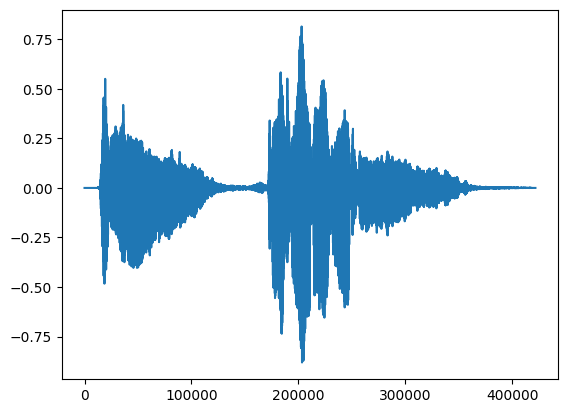

In [4]:
rate, file = read("被遺忘的時光intro.wav")
fixed_data0 = file[:, 0]
fixed_data1 = file[:, 1]

float_data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
float_data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

dataSet, data0, length, iteration = PreProcessData(float_data0, frameSize, stepSize)
dataSet, data1, length, iteration = PreProcessData(float_data1, frameSize, stepSize)

plt.plot(data0)
plt.show()

IPython.display.display(IPython.display.Audio("被遺忘的時光intro.wav", rate = rate))

### Define Room Impulse Response Arguments
1. Speed of Sound
2. Sample Rate
3. Receive Location(Could be 2D or 3D)
4. Source Location(Could be 2D or 3D)
5. Room Size
6. Reverb Time
7. Impulse Length
8. Microphone Type
9. Reflection Order
10. Room Dimension(Could be 2D or 3D)
11. Microphone Orientation
12. Enable high-pass filer?

In [5]:
# Sound velocity (m/s)
c = 343

# Sample frequency (samples/s)
fs = 48000

# Receiver position [ x y z ] (m)
r = [1.1, 1, 1.2]

# Source position [ x y z ] (m)
s = [2, 3, 2]

# Room dimensions [ x y z ] (m)
L = [3.2, 4, 2.7]

# Absorption
beta = [-0.92] * 6

# Number of samples
nsample = frameSize

# Type of microphone
mtype = "hypercardioid"

# −1 equals maximum reflection order!
order = -1

# Room dimension
dim = 3

# Microphone orientation [azimuth elevation] in radians
orientation = [np.pi / 2]

# Enable high-pass filter
hp_filter = True

taps = RG.rir_generator(c, fs, r, s, L, beta=beta, nsample=nsample, mtype=mtype, order=order, dim=dim, orientation=orientation, hp_filter=hp_filter)

w, h = signal.freqz(taps)

amplitude = 20 * np.log10(abs(h))
angle = np.unwrap(np.angle(h))

### Time Domain Data

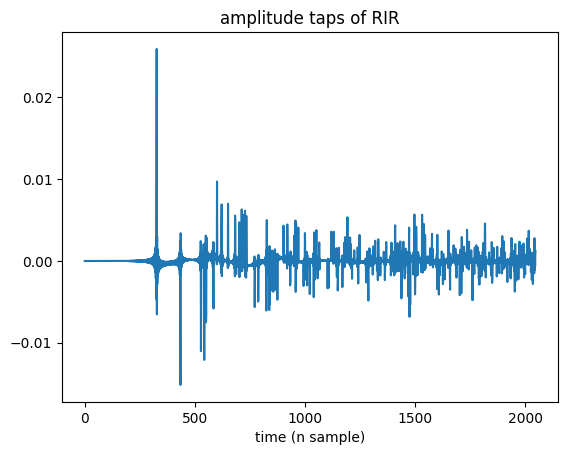

In [6]:
plt.title('amplitude taps of RIR')
plt.xlabel(r'time (n sample)')
plt.plot(taps)
plt.show()

### Frequency Domain Data

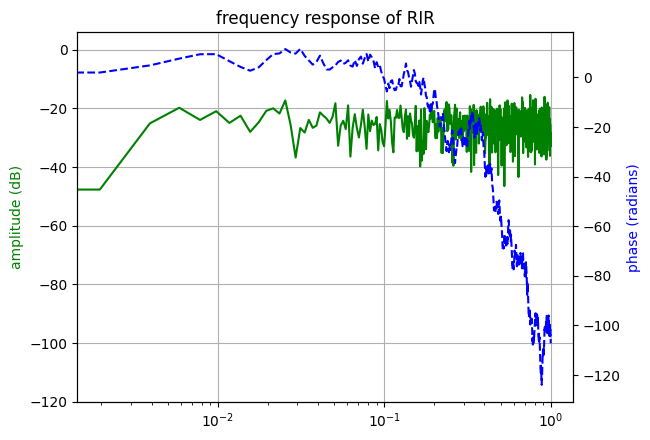

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('frequency response of RIR')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-120, 6)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')

plt.xscale("log")
plt.show()

### Making Linear Convolution

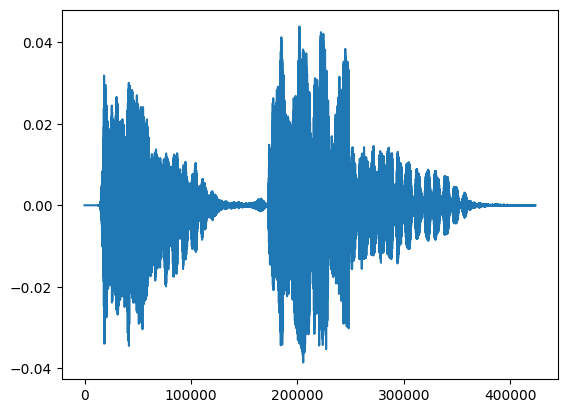

In [8]:
outputData0 = signal.convolve(taps, data0)
outputData1 = signal.convolve(taps, data1)

temp = np.array([outputData0,outputData1])

write("fir_linear_conv.wav", rate, np.transpose(temp * 32767.0).astype(np.int16))

plt.plot(outputData0)
plt.show()

IPython.display.display(IPython.display.Audio("fir_linear_conv.wav", rate=rate))

### Implementation

In [9]:
from collections import defaultdict

class ISM:

    def __init__(self):
        pass

    def defineSystem(self, fs, velocity, sample, order, time=0.004):
        self.fs = fs
        self.velocity = velocity
        self.width = int(2 * np.round(time * fs) + 1)
        self.width_half = int(np.round(time * fs))
        self.time_width = np.arange(self.width)
        self.cTs = velocity / fs
        self.hann_window = 0.5 * (1 + np.cos(np.linspace(-np.pi, np.pi, self.width)))
        self.nSamples = sample
        self.order = order

    def createRoom(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.volume = self.x * self.y * self.z
        self.surface = 2 * (self.x * self.y + self.x * self.z + self.y * self.z)
        self.dimension = np.array([x, y, z])
        self.l = np.array([x, y, z]) / self.cTs
        self.mt = np.sqrt(self.volume)
        self.mt_ = self.mt/1000*self.fs

    def addMicrophone(self, x, y, z):
        self.mircophone = np.array([x, y, z])
        self.r = np.array([x, y, z]) / self.cTs

    def addSource(self, x, y, z):
        self.source = np.array([x, y, z])
        self.s = np.array([x, y, z]) / self.cTs

    def createMaterialByCoefficient(self, x1, x2, y1, y2, z1, z2):
        # define reflection coefficient
        self.beta = np.array([x1, x2, y1, y2, z1, z2])

        # Sabin-Franklin’s formula
        # RT_60 = \frac { 24 * ln(10) * V } { c * \sum_{i = 1}^{6} S_i * (1 - beta_i^{2}) }
        alpha = (1 - np.power(x1, 2)) * self.y * self.z + \
                (1 - np.power(x2, 2)) * self.y * self.z + \
                (1 - np.power(y1, 2)) * self.x * self.z + \
                (1 - np.power(y2, 2)) * self.x * self.z + \
                (1 - np.power(z1, 2)) * self.x * self.y + \
                (1 - np.power(z2, 2)) * self.x * self.y
        self.alpha = alpha
        if(alpha > 0):
            self.reverberation = 24 * np.log(10.0) * self.volume / (self.velocity * alpha)

    def createMaterialByTime(self, reverberation_time):
        if (reverberation_time != 0):
            alpha = 24 * np.log(10.0) * self.volume / (self.velocity * self.surface * reverberation_time)
            self.alpha = alpha
            beta = np.sqrt(1 - alpha)
            self.beta = np.full(6, beta)
            return self.beta

    def computeRIR(self):
        imp = np.zeros(self.nSamples, dtype=np.double)

        # frequency cut-off of idea low pass filter
        fc = 1

        n1 = int(np.ceil(self.nSamples / (2 * self.l[0])))
        n2 = int(np.ceil(self.nSamples / (2 * self.l[1])))
        n3 = int(np.ceil(self.nSamples / (2 * self.l[2])))

        Rm = np.zeros(3)
        Rp = np.zeros(3)
        
        cluster = defaultdict(list)

        # Generate room impulse response
        for mx in range(-n1, n1 + 1, 1):
            Rm[0] = 2 * mx * self.l[0]

            for my in range(-n2, n2 + 1, 1):
                Rm[1] = 2 * my * self.l[1]

                for mz in range(-n3, n3 + 1, 1):
                    Rm[2] = 2 * mz * self.l[2]

                    for q in range(2):
                        Rp[0] = (1 - 2 * q) * self.s[0] - self.r[0]
                        ISM_X = Rm[0] + (1 - 2 * q) * self.s[0]
                        beta_x1 = np.power(self.beta[0], np.abs(mx - q))
                        beta_x2 = np.power(self.beta[1], np.abs(mx))

                        for j in range(2):
                            Rp[1] = (1 - 2 * j) * self.s[1] - self.r[1]
                            ISM_Y = Rm[1] + (1 - 2 * j) * self.s[1]
                            beta_y1 = np.power(self.beta[2], np.abs(my - j))
                            beta_y2 = np.power(self.beta[3], np.abs(my))

                            for k in range(2):
                                Rp[2] = (1 - 2 * k) * self.s[2] - self.r[2]
                                ISM_Z = Rm[2] + (1 - 2 * k) * self.s[2]
                                beta_z1 = np.power(self.beta[4], np.abs(mz - k))
                                beta_z2 = np.power(self.beta[5], np.abs(mz))

                                order = abs(2 * mx - q) + abs(2 * my - j) + abs(2 * mz - k)
                                dist_in_sample = np.sqrt(np.sum(np.power(Rm + Rp, 2)))
                                fdist_in_sample = np.floor(dist_in_sample)
                                
                                temp = dict()
                                temp['dist'] = dist_in_sample * self.cTs
                                temp['start'] = int(fdist_in_sample - self.width_half)
                                temp['center'] = fdist_in_sample
                                temp['end'] = int(fdist_in_sample + self.width_half)
                                temp['beta'] = np.array([beta_x1, beta_x2, beta_y1, beta_y2, beta_z1, beta_z2])
                                temp['image_source'] = np.array([ISM_X, ISM_Y, ISM_Z]) * self.cTs
                                temp['q'] = q
                                temp['j'] = j
                                temp['k'] = k
                                temp['Rm'] = Rm * self.cTs
                                temp['Rp'] = Rp * self.cTs
                                
                                cluster[order].append(temp) 
                                
                                if order <= self.order or self.order == -1:
                                    
                                    if fdist_in_sample < self.nSamples:
                                        dist = dist_in_sample * self.cTs
                                        gain = 1 * beta_x1 * beta_x2 * beta_y1 * beta_y2 * beta_z1 * beta_z2 / (4 * np.pi * dist)

                                        t = (self.time_width - self.width_half) - (dist_in_sample - fdist_in_sample)
                                        LPI = self.hann_window * np.sinc(fc * t)

                                        startPosition = int(fdist_in_sample - self.width_half)
                                        
                                        for n in range(self.width):
                                            if startPosition + n >= 0 and startPosition + n < self.nSamples:
                                                imp[startPosition + n] = imp[startPosition + n] + gain * LPI[n]
        return imp.T, cluster

In [10]:
instance = ISM()
instance.defineSystem(16000, 343, frameSize*2, 13)
instance.createRoom(5, 10, 2.2)
instance.createMaterialByCoefficient(-0.92, -0.92, -0.92, -0.92, -0.92, -0.92)
instance.addMicrophone(1.2, 5, 1.5)
instance.addSource(3.5, 5, 1.5)
imp, cluster = instance.computeRIR()

In [11]:
cluster_size = len(cluster)
imp = np.zeros((instance.nSamples, cluster_size))

for order in range(cluster_size):
    for index, block in enumerate(cluster[order]):    
        dist_in_sample = cluster[order][index]['dist'] / instance.cTs
        fdist_in_sample = int(dist_in_sample)
        dist = cluster[order][index]['dist']
        beta = cluster[order][index]['beta']
        startPosition = cluster[order][index]['start']
        
        if fdist_in_sample < instance.nSamples:
            gain = beta[0] * beta[1] * beta[2] * beta[3] * beta[4] * beta[5] / (4 * np.pi * dist)

            t = (instance.time_width - instance.width_half) - (dist_in_sample - fdist_in_sample)
            LPI = instance.hann_window * np.sinc(t)
            for n in range(instance.width):
                if startPosition + n >= 0 and startPosition + n < instance.nSamples:
                    imp[startPosition + n][order] = imp[startPosition + n][order] + gain * LPI[n]

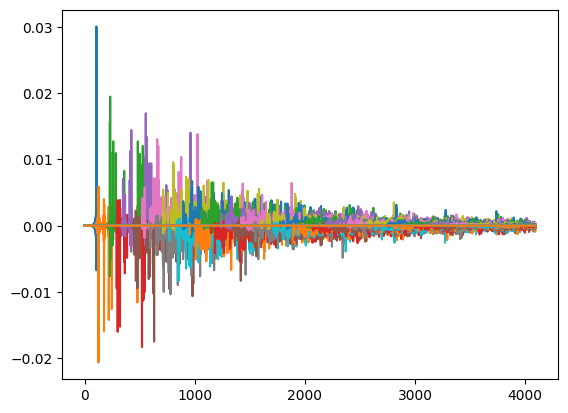

In [12]:
plt.plot(imp[:,:])
plt.show()

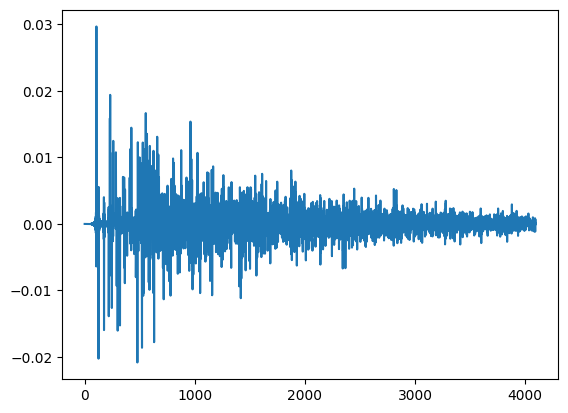

In [13]:
plt.plot(np.sum(imp[:,:], axis=1))
plt.show()

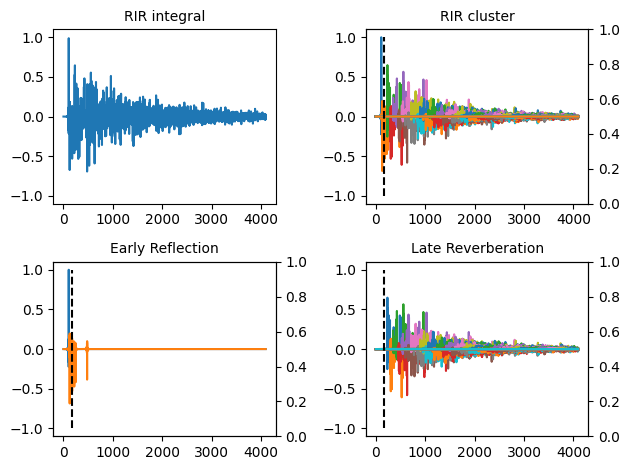

In [22]:
norm = np.max(imp[:,:])

fig, axs = plt.subplots(nrows=2, ncols=2)

axs[0][0].plot(np.sum(imp[:,:] / norm, axis=1))
axs[0][0].set_ylim(-1.1, 1.1)
axs[0][0].set_title('RIR integral', fontsize=10)

ax2 = axs[0][1].twinx()
axs[0][1].plot(imp[:,:] / norm)
axs[0][1].vlines(instance.mt_,  -1, 1, color='k', linestyle='--')
axs[0][1].set_ylim(-1.1, 1.1)
axs[0][1].set_title('RIR cluster', fontsize=10)

ax2 = axs[1][0].twinx()
axs[1][0].plot(imp[:,:2] / norm)
axs[1][0].vlines(instance.mt_,  -1, 1, color='k', linestyle='--')
axs[1][0].set_ylim(-1.1, 1.1)
axs[1][0].set_title('Early Reflection', fontsize=10)

ax2 = axs[1][1].twinx()
axs[1][1].plot(imp[:,2:] / norm)
axs[1][1].vlines(instance.mt_,  -1, 1, color='k', linestyle='--')
axs[1][1].set_ylim(-1.1, 1.1)
axs[1][1].set_title('Late Reverberation', fontsize=10)

plt.tight_layout()
plt.show()

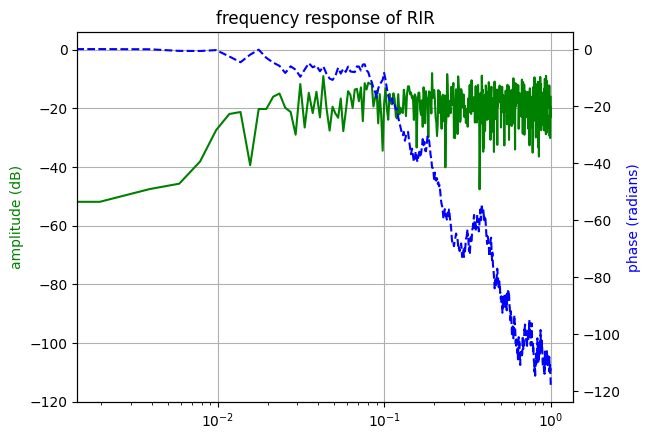

In [15]:
w, h = signal.freqz(np.sum(imp[:,:], axis=1))

amplitude = 20 * np.log10(abs(h))
angle = np.unwrap(np.angle(h))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('frequency response of RIR')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-120, 6)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')

plt.xscale("log")
plt.show()

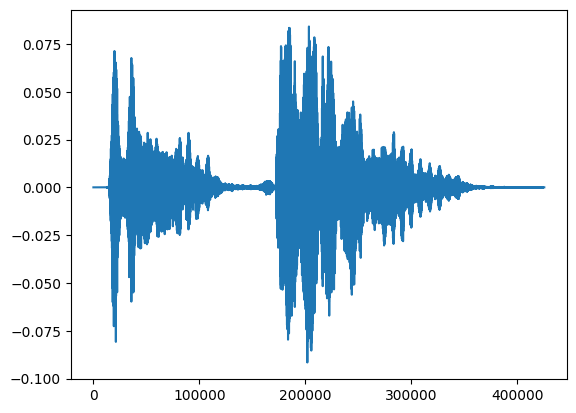

In [16]:
outputData0 = signal.convolve(np.sum(imp[:,:], axis=1), data0)
outputData1 = signal.convolve(np.sum(imp[:,:], axis=1), data1)

temp = np.array([outputData0,outputData1])

write("fir_linear_conv_v2.wav", rate, np.transpose(temp * 32767.0).astype(np.int16))

plt.plot(outputData0)
plt.show()

IPython.display.display(IPython.display.Audio("fir_linear_conv_v2.wav", rate=rate))